In [16]:
import wandb
import numpy as np
from scipy.optimize import minimize
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
import plotly.graph_objs as go
import matplotlib as mpl

In [17]:
mpl.style.use('seaborn-v0_8')
mpl.rcParams['figure.figsize'] = (15,10)
fontsize = 20
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize'] = fontsize

In [2]:

# Define dimensions
f = 10  # Input/Output dimensions
n = 2   # Hidden layer dimensions

# Create synthetic dataset
class SyntheticDataset(Dataset):
    def __init__(self, num_samples, f):
        self.num_samples = num_samples
        self.f = f
        self.data = self.generate_data()
        
    def generate_data(self):
        data = torch.zeros((self.num_samples, self.f))
        for i in range(self.num_samples):
            index = torch.randint(0, self.f, (1,))
            data[i, index] = torch.rand(1)
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

class SyntheticNormalised(Dataset):
    def __init__(self, f):
        self.f = f
        self.data = self.generate_data()
        
    def generate_data(self):
        return torch.eye(self.f)

    def __len__(self):
        return self.f

    def __getitem__(self, idx):
        return self.data[idx]


# Create fully connected neural network
class FCNet(nn.Module):
    def __init__(self, f, n, final_bias = False):
        super(FCNet, self).__init__()
        self.embedding = nn.Linear(f, n, bias = False)
        self.unembedding = nn.Linear(n, f, bias = final_bias)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.relu(self.unembedding(x))
        return x

class FCNetTied(nn.Module):
    def __init__(self, input_dim, hidden_dim, final_bias = False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Define the input layer (embedding)
        self.embedding = nn.Linear(self.input_dim, self.hidden_dim, bias=False)

        # Define the output layer (unembedding)
        self.unembedding = nn.Linear(self.hidden_dim, self.input_dim, bias=final_bias)

        # Tie the weights
        self.unembedding.weight = torch.nn.Parameter(self.embedding.weight.transpose(0, 1))

    def forward(self, x):
        x = self.embedding(x)
        x = self.unembedding(x)
        x = torch.relu(x)
        return x


def plot_weights(weight_matrix, jitter = 0.05, normalised = False, save = False, epoch = None):
    plt.figure(figsize=(8, 8))

    for i in range(weight_matrix.shape[0]):
        normalisation = (weight_matrix[i,0]**2 + weight_matrix[i,1]**2) **0.5 if normalised else 1 
        plt.arrow(0, 0, weight_matrix[i,0]/normalisation, weight_matrix[i,1]/normalisation, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
        plt.text(weight_matrix[i,0]/normalisation + jitter * torch.randn(1), weight_matrix[i,1]/normalisation + jitter * torch.randn(1), f"{i}", color='red', fontsize=12)

    mins = -1.2 if normalised else weight_matrix.min()-0.5
    maxs = 1.2 if normalised else weight_matrix.max()+0.5
    plt.xlim(mins,maxs)
    plt.ylim(mins,maxs)
    plt.grid()
    if save:
        assert epoch is not None
        plt.savefig(f"weights_{epoch}.png")
    plt.close()

 20%|█▉        | 59913/300000 [00:33<02:10, 1838.56it/s]

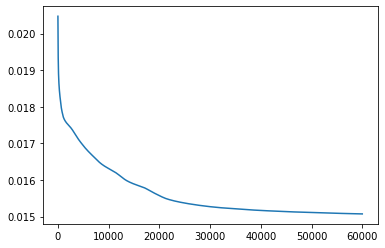

 40%|███▉      | 119886/300000 [01:05<01:37, 1841.81it/s]

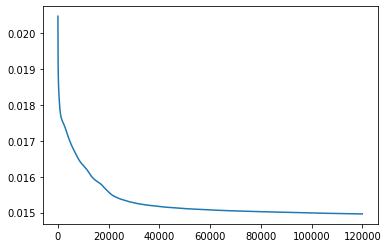

 60%|█████▉    | 179926/300000 [01:38<01:05, 1844.85it/s]

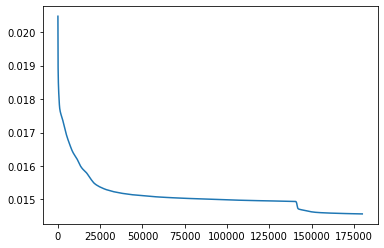

 80%|███████▉  | 239944/300000 [02:11<00:32, 1842.00it/s]

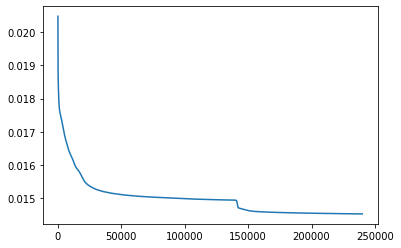

100%|█████████▉| 299868/300000 [02:44<00:00, 1836.84it/s]

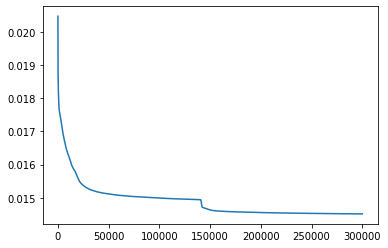

100%|██████████| 300000/300000 [02:44<00:00, 1825.11it/s]


In [3]:
using_wandb = False
logging_loss = True
new_run = True
# Start a new run
if using_wandb:
  run = wandb.init(project="tiny_superposition", entity="jake-mendel")
if logging_loss:
    if new_run:
        losses = []

# Configure the hyperparameters
f = 50
n = 3
batch_size = 200
epochs = 300000
learning_rate = 5
image_store_rate = 200
plot_rate=epochs/5
# print_rate = 5000
if using_wandb:
    config = wandb.config
    f = f
    config.n = n
    config.batch_size = batch_size
    config.epochs = epochs
    config.learning_rate = learning_rate
    config.image_store_rate = image_store_rate

# Instantiate synthetic dataset
dataset = SyntheticNormalised(f)
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

# Instantiate the model
if new_run:
    model = FCNet(f, n, final_bias = False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Define a learning rate schedule
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//100, gamma=3000**(-100))

# Watch the model
if using_wandb:
  wandb.watch(model)

# Training
def train(model, loader, criterion, optimizer, epochs):
    embeddings_history = []  # Store the weights here
    unembeddings_history = []  # Store the weights here
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        if using_wandb:
            wandb.log({"epoch": epoch, "loss": avg_loss})
        if logging_loss:
           losses.append(avg_loss)
           if (epoch + 1) % plot_rate == 0:
               plt.plot(losses)
               plt.show()
        # if (epoch + 1) % print_rate == 0:
        #   print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        # Every image_store_rate epochs, save weights
        if (epoch + 1) % image_store_rate == 0:
            embedding_matrix = model.embedding.weight.detach().numpy().copy().T
            unembedding_matrix = model.unembedding.weight.detach().numpy().copy()
            embeddings_history.append(embedding_matrix)
            unembeddings_history.append(unembedding_matrix)
    scheduler.step()
    return embeddings_history, unembeddings_history  # Return the weights history

# Train the model
if new_run:
    embedding_history, unembedding_history = train(model, loader, criterion, optimizer, epochs)
else:
   weights_history += train(model, loader, criterion, optimizer, epochs)

# Close the wandb run
if using_wandb:
  run.finish()


In [32]:


def plot_weights_interactive(weights_history, x_dir = None, y_dir = None):
    # Initialize figure
    fig = go.Figure()

    assert type(x_dir) == type(y_dir)
    if isinstance(x_dir, np.ndarray):
        assert len(x_dir) == weights_history[0].shape[-1]
    if x_dir is None:
        x_dir, y_dir = (np.zeros(weights_history[0].shape[-1]), np.zeros(weights_history[0].shape[-1]))
        x_dir[0] = 1
        y_dir[1] = 1
    elif isinstance(x_dir,int):
        x = x_dir
        y = y_dir
        x_dir, y_dir = (np.zeros(weights_history[0].shape[-1]), np.zeros(weights_history[0].shape[-1]))
        x_dir[x] = 1
        y_dir[y] = 1
    else:
        if isinstance(x_dir,list):
            x_dir = np.array(x_dir)
            y_dir = np.array(y_dir)
        assert isinstance(x_dir, np.ndarray)
        assert len(x_dir) == weights_history[0].shape[-1]
    
    # Create a scatter plot for each weight matrix
    for i, weight_matrix in enumerate(weights_history):
        # Convert weight matrix into arrow endpoints and labels
        x_values = weight_matrix @ x_dir
        y_values = weight_matrix @ y_dir
        labels = list(range(len(x_values)))

        # Create scatter plot
        scatter = go.Scatter(x=x_values, y=y_values, mode='markers+text', text=labels,
                             textposition='top center', marker=dict(size=8), visible = False, name=f'Epoch {i*image_store_rate}')

        fig.add_trace(scatter)
    
    # Make the first scatter plot visible
    fig.data[0].visible = True

    # Update xaxis and yaxis properties
    fig.update_xaxes(title_text='X Value', range=[-1, 1])
    fig.update_yaxes(title_text='Y Value', range=[-1, 1])

    # Add a slider to switch between epochs
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method='restyle',
            args=['visible', [False] * len(fig.data)],
            label=f'Epoch {i * image_store_rate}'
        )
        step['args'][1][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    sliders = [dict(steps=steps, active=0)]

    fig.update_layout(sliders=sliders, width=800, height=800)

    fig.show()

# plot_weights_interactive(embedding_history)


In [33]:
def plot_weights_interactive_3d(weights_history, visualisation = 'points', numbering=False):
    # Initialize figure
    fig = go.Figure()

    # Calculate maximum value of all components
    max_value = np.max([np.abs(weight_matrix).max() for weight_matrix in weights_history])

    # Create a scatter plot for each weight matrix
    for i, weight_matrix in tqdm(enumerate(weights_history)):
        # Convert weight matrix into arrow endpoints and labels
        x_values = weight_matrix[:,0]
        y_values = weight_matrix[:,1]
        z_values = weight_matrix[:,2]
        labels = list(range(len(x_values))) if numbering else ['' for _ in range(len(x_values))]

        # Create scatter plot
        if visualisation == 'points':
            scatter = go.Scatter3d(x=x_values, y=y_values, z=z_values, mode='markers+text', text=labels,
                                textposition='middle center', marker=dict(size=4), visible=False, name=f'Epoch {i*image_store_rate}')
            fig.add_trace(scatter)
        elif visualisation == 'lines':
            for j in range(len(x_values)):
                # Create arrow body as a line
                line = go.Scatter3d(x=[0, x_values[j]], y=[0, y_values[j]], z=[0, z_values[j]], 
                                    mode='lines',
                                    line=dict(width=2, color='blue'),
                                    showlegend=False,
                                    visible=False)
                fig.add_trace(line)

    # Make the first scatter plot visible
    fig.data[0].visible = True

    # Update xaxis, yaxis, and zaxis properties to use the calculated maximum value
    fig.update_layout(scene = dict(
                    xaxis=dict(range=[-max_value,max_value], title='X Value'),
                    yaxis=dict(range=[-max_value,max_value], title='Y Value'),
                    zaxis=dict(range=[-max_value,max_value], title='Z Value')))

    fig.update_layout(scene = dict(
                    xaxis_title='X Value',
                    yaxis_title='Y Value',
                    zaxis_title='Z Value'))

    # Add a slider to switch between epochs
    steps = []
    for i in tqdm(range(len(fig.data))):
        step = dict(
            method='restyle',
            args=['visible', [False] * len(fig.data)],
            label=f'Epoch {i * image_store_rate}'
        )
        step['args'][1][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    sliders = [dict(steps=steps, active=0)]
    fig.update_layout(sliders=sliders, width=800, height=800)

    fig.show()

# plot_weights_interactive_3d(embedding_history,'points', False)


In [34]:
# plot_weights_interactive_3d(unembedding_history,'points', False)


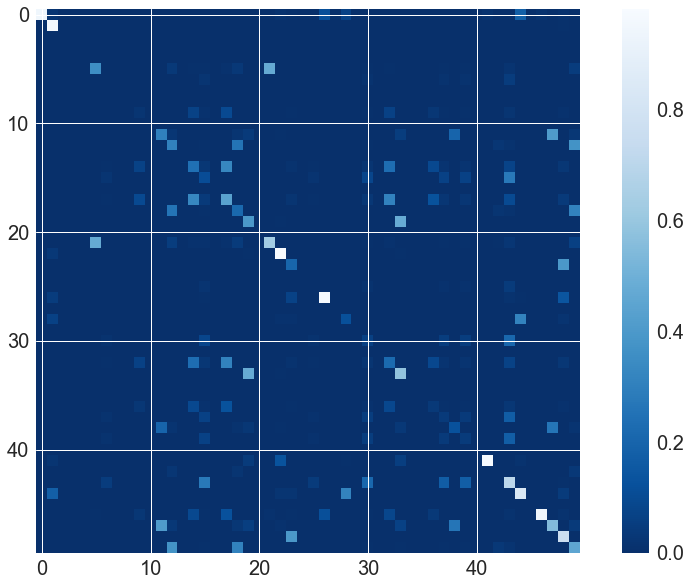

In [27]:
relued = torch.nn.functional.relu(torch.tensor(embedding_history[-1]@unembedding_history[-1].T)).detach().numpy()
prerelu = embedding_history[-1]@unembedding_history[-1].T
plt.imshow(relued, cmap = 'Blues_r')
plt.colorbar()

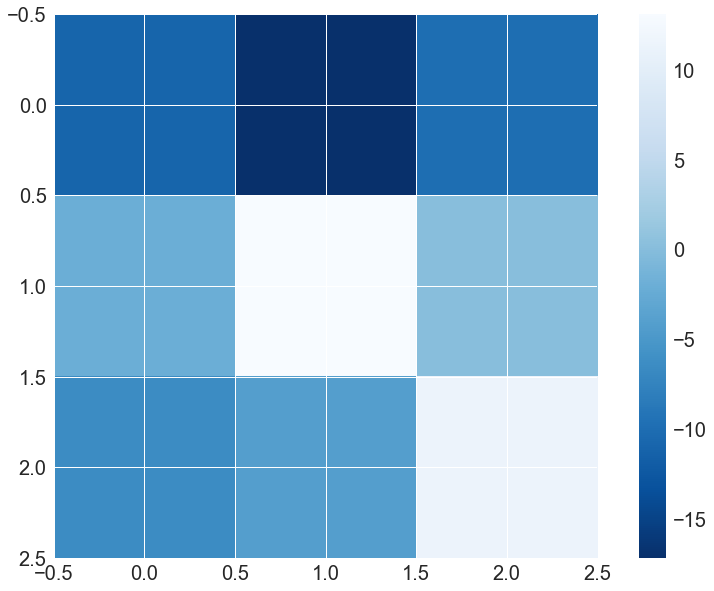

In [31]:
relued = torch.nn.functional.relu(torch.tensor(embedding_history[-1].T@unembedding_history[-1])).detach().numpy()
prerelu = embedding_history[-1].T@unembedding_history[-1]
plt.imshow(prerelu, cmap = 'Blues_r')
plt.colorbar()

In [45]:
def normalise(matrix):
    out = np.zeros_like(matrix)
    for i,row in enumerate(matrix):
        norm = (row.T @ row) ** 0.5
        out[i] = row / norm
    return out

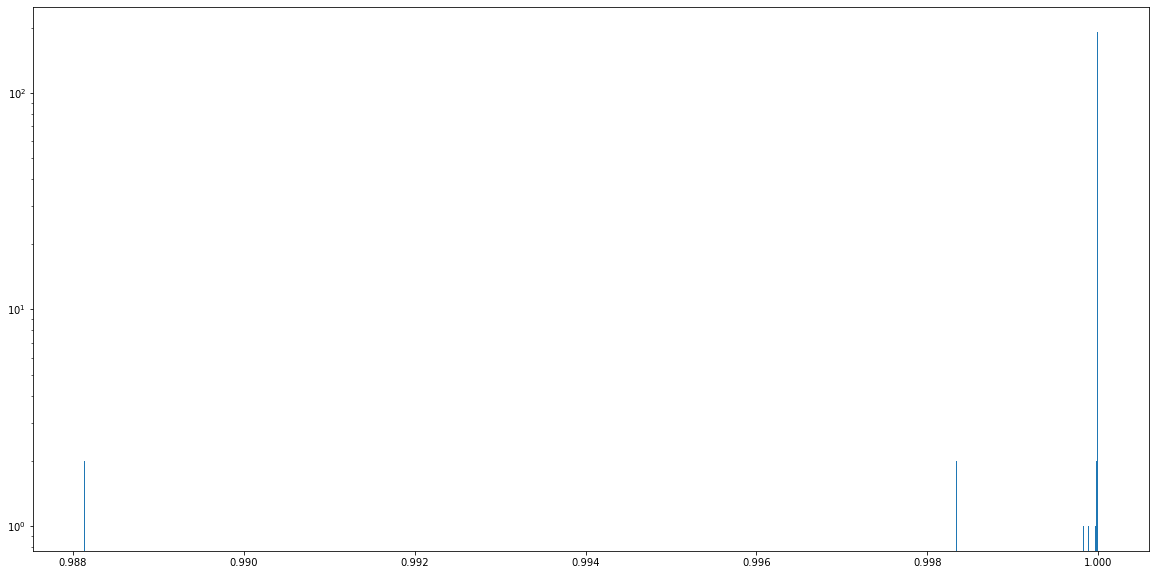

In [256]:
max_prods = []
normalised = normalise(weights_history[-1])
for i,row1 in enumerate(normalised):
    rowprods = []
    for j,row2 in enumerate(normalised):
        if i != j:
            rowprods.append(row1.T@row2)
    max_prods.append(max(rowprods))

plt.figure(figsize = (20,10))
plt.hist(max_prods, bins = 1000, log = True)
plt.show()

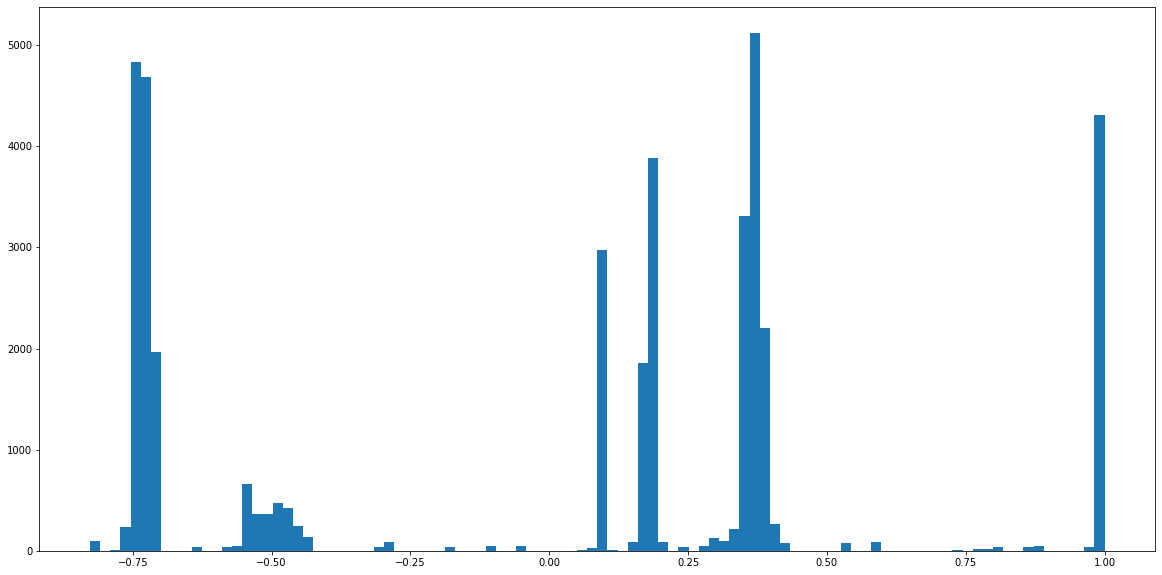

In [282]:
prods = []
normalised = normalise(weights_history[-1])
for i in normalised:
    for j in normalised:
        prods.append(i.T @ j)
plt.figure(figsize = (20,10))
plt.hist(prods, bins = 100)
plt.show()

In [260]:
def group_vectors(vectors, epsilon):
    # Store the groups of similar vectors here
    groups = []
    norms = []
    directions = []

    for v in vectors:
        # Normalize the current vector
        v_norm = v / np.linalg.norm(v)
        if np.linalg.norm(v) < 0.01:
            continue

        # This flag will tell us if the current vector has been added to any group
        added_to_group = False

        # Go through each existing group to check if this vector belongs there
        for i,group in enumerate(groups):
            # We use the first vector in the group as representative
            group_representative = group[0]
            group_representative_norm = group_representative / np.linalg.norm(group_representative)

            # Calculate the dot product between the normalized vectors
            dot_product = np.dot(v_norm, group_representative_norm)

            # Check if the dot product is close enough to 1 (indicating they are scalar multiples of each other)
            if np.abs(dot_product - 1) < epsilon:
                group.append(v)
                norms[i].append(v_norm)
                added_to_group = True
                break

        # If the current vector has not been added to any group, we create a new group for it
        if not added_to_group:
            groups.append([v])
            norms.append([v_norm])
    
    for norm in norms:
        arr = np.array(norm)
        directions.append(np.mean(arr,axis=0))

        

    return groups,directions


In [261]:
groups,directions = group_vectors(weights_history[-1], 0.05)
print(len(directions))
print([len(group) for group in groups])

In [163]:
d_matrix = np.array(directions)
np.mean(d_matrix, axis = 0)

array([-0.05755628,  0.0114938 ,  0.07402066, -0.00770386], dtype=float32)

In [94]:


def visualize_3d_vectors(matrix):
    """
    Visualize a set of 3D vectors in a 3D plot.

    Args:
    matrix (np.array): A numpy array where each row is a 3D vector.
    """

    # Create an empty figure
    fig = go.Figure()

    # For each vector in the matrix, plot a line from the origin to the point defined by the vector
    for vector in matrix:
        fig.add_trace(go.Scatter3d(
            x=[0, vector[0]],
            y=[0, vector[1]],
            z=[0, vector[2]],
            mode='lines',
        ))

    # Update layout for better view
    fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
    # Show the plot
    fig.show()


In [264]:
U,S,V = np.linalg.svd(d_matrix)
S

array([1.9846582, 1.9291772, 1.7771133, 1.7769732], dtype=float32)

In [95]:
visualize_3d_vectors(d_matrix)

In [65]:
def dimensionality(directions):
    out = []
    for w_i in directions:
        interference = 0
        for w_j in directions:
            interference += np.dot(w_i,w_j)**2
        out.append(1/interference)
    return out

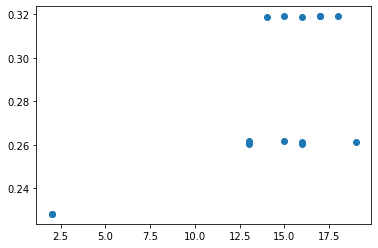

In [265]:
plt.scatter([len(g) for g in groups], dimensionality(directions))

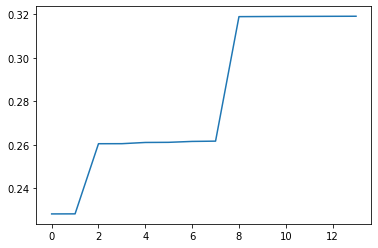

In [266]:
plt.plot(sorted(dimensionality(directions)))

In [269]:
a = np.array([[round(np.mean(normalise(groups[i]),axis=0).T @ np.mean(normalise(groups[j]), axis = 0),4) for j in range(len(groups)) if j != i] for i in range(len(groups))])
sorted(a.flatten(), reverse=True)[:10]

[0.7334,
 0.7334,
 0.6491,
 0.6491,
 0.6463,
 0.6463,
 0.6436,
 0.6436,
 0.6371,
 0.6371]

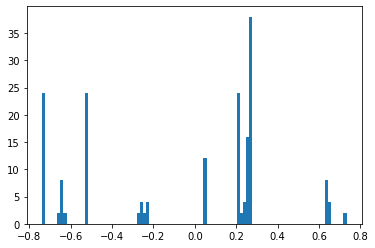

In [270]:
plt.hist(a.flatten(), bins = 100)
plt.show()

In [271]:
sorted(dimensionality(directions))

[0.22828316633132162,
 0.22831077254429674,
 0.26053879916348105,
 0.2605581905610773,
 0.26111543781477403,
 0.26117831365079364,
 0.26159716251151627,
 0.2617243933829933,
 0.3189320715575847,
 0.3189806675658207,
 0.31902635126875845,
 0.3190553771410771,
 0.3190871698718389,
 0.3191157053685926]

In [275]:
np.array([dimensionality(directions), [len(g) for g in groups]]).T


array([[ 0.26159716, 13.        ],
       [ 0.31898067, 14.        ],
       [ 0.31908717, 17.        ],
       [ 0.26117831, 19.        ],
       [ 0.22828317,  2.        ],
       [ 0.2605388 , 16.        ],
       [ 0.26111544, 16.        ],
       [ 0.31902635, 18.        ],
       [ 0.31893207, 16.        ],
       [ 0.26172439, 15.        ],
       [ 0.31905538, 15.        ],
       [ 0.31911571, 17.        ],
       [ 0.26055819, 13.        ],
       [ 0.22831077,  2.        ]])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

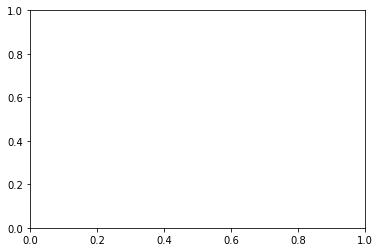

In [31]:
plt.plot([model(SyntheticNormalised(f)[i]).argmax() for i in range(f)])